# Project 4 - Loblaws Digital - Customer Attrition Prediction
### Team 5- Harsh, Hosang, Simran

In [198]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats

### Load the Dataset

In [199]:
# Load the dataset
df = pd.read_csv('../data/loblaws.csv')

# Display the first few rows of the dataset
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

Churn
0    4682
1     948
Name: count, dtype: int64


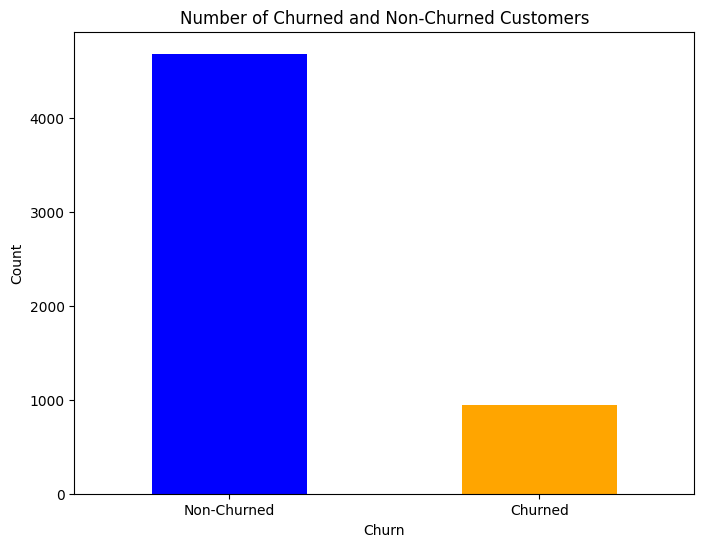

In [201]:
# Count the number of churned and non-churned customers
churn_counts = df['Churn'].value_counts()
print(churn_counts)

# Plot the number of churned and non-churned customers
plt.figure(figsize=(8, 6))
churn_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Churned and Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Churned', 'Churned'], rotation=0)
plt.show()

In [202]:
# Encode string columns to numerical values
df = df.drop(columns=['CustomerID'])
string_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in string_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

### Handling Missing Values

In [203]:
# Separate the dataframes based on Churn value
df_churn_0 = df[df['Churn'] == 0].dropna()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_churn_1 = df[df['Churn'] == 1].copy()
df_churn_1[numeric_cols] = df_churn_1[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Print the count of each dataframe
print("Count of Non-Churned Customers (after removing nulls):", len(df_churn_0))
print("Count of Churned Customers (after imputing median values):", len(df_churn_1))

Count of Non-Churned Customers (after removing nulls): 3143
Count of Churned Customers (after imputing median values): 948


In [204]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, cols, threshold=1.5):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers in df_churn_0
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_churn_0_cleaned = remove_outliers_iqr(df_churn_0, numeric_cols)

# Print the count of each cleaned dataframe
print("Count of Non-Churned Customers (after removing nulls and outliers):", len(df_churn_0_cleaned))
print("Count of Churned Customers (no outliers removed):", len(df_churn_1))

Count of Non-Churned Customers (after removing nulls and outliers): 1561
Count of Churned Customers (no outliers removed): 948


Churn
0    1561
1     948
Name: count, dtype: int64


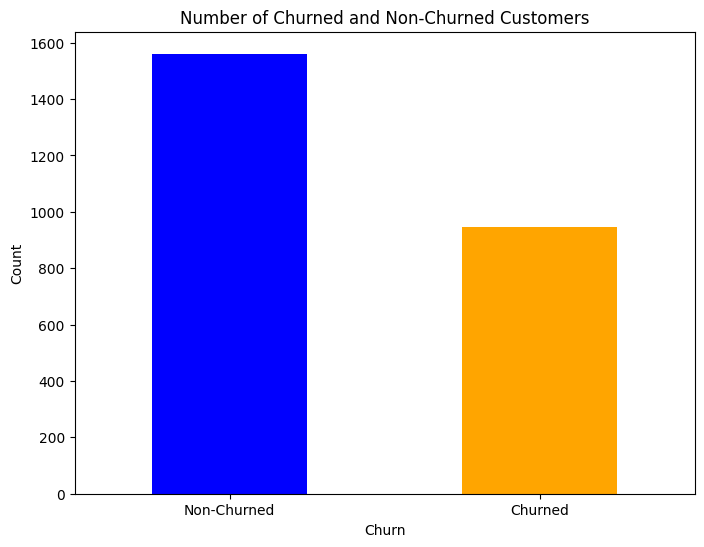

In [205]:
# merge data frame
df_cleaned = pd.concat([df_churn_0_cleaned, df_churn_1])

# Count the number of churned and non-churned customers
churn_counts = df_cleaned['Churn'].value_counts()
print(churn_counts)

# Plot the number of churned and non-churned customers
plt.figure(figsize=(8, 6))
churn_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Churned and Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Churned', 'Churned'], rotation=0)
plt.show()

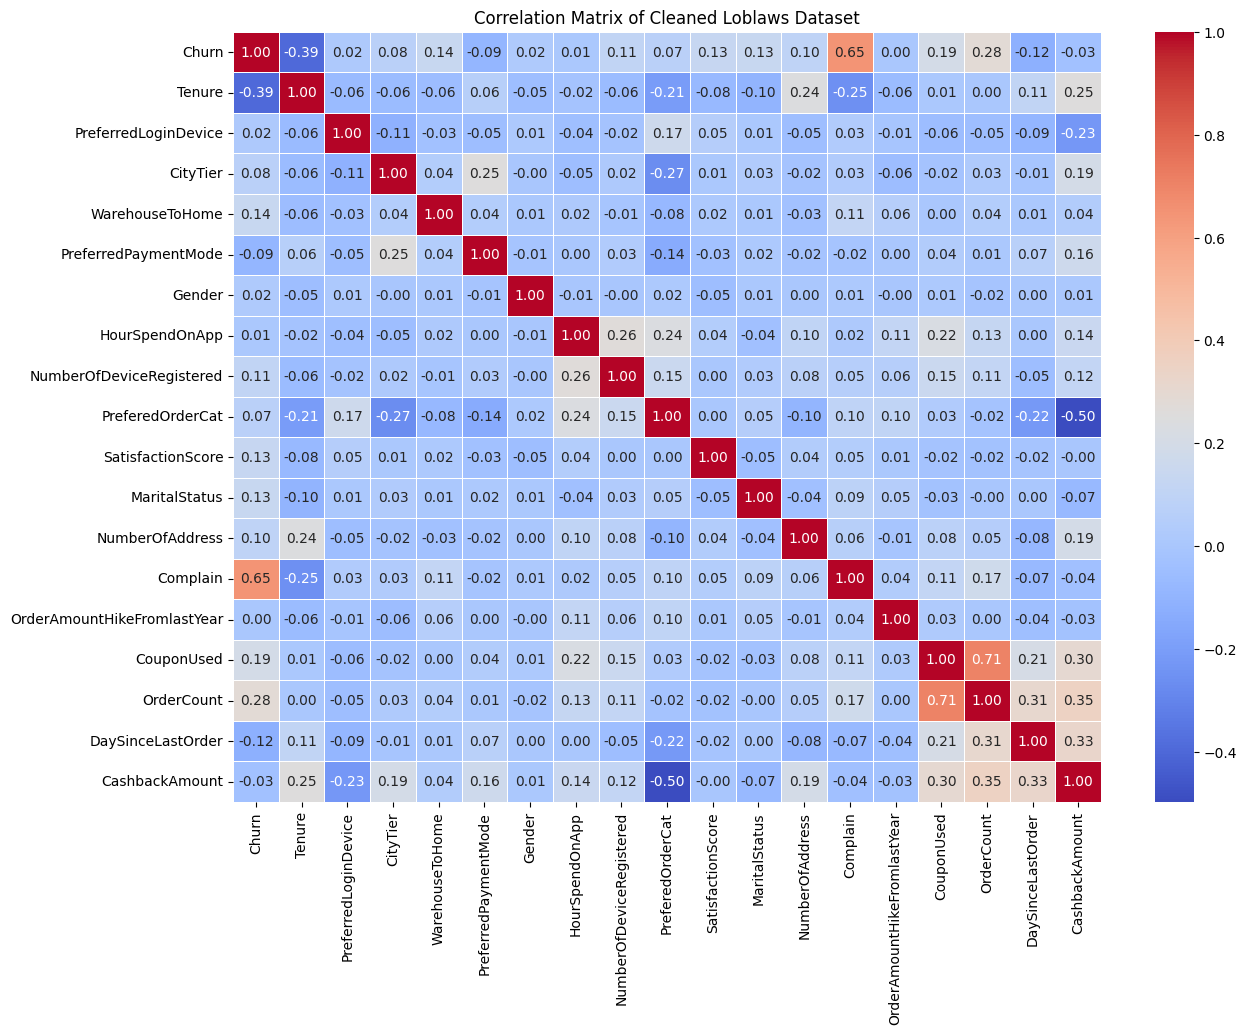

In [206]:
# correlation matrix
corr_matrix = df_cleaned.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Cleaned Loblaws Dataset')
plt.show()

C:\Users\flag8\AppData\Local\Temp\ipykernel_55060\2171541942.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Tenure', data=df, palette='viridis')
C:\Users\flag8\AppData\Local\Temp\ipykernel_55060\2171541942.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='OrderCount', data=df, palette='viridis')


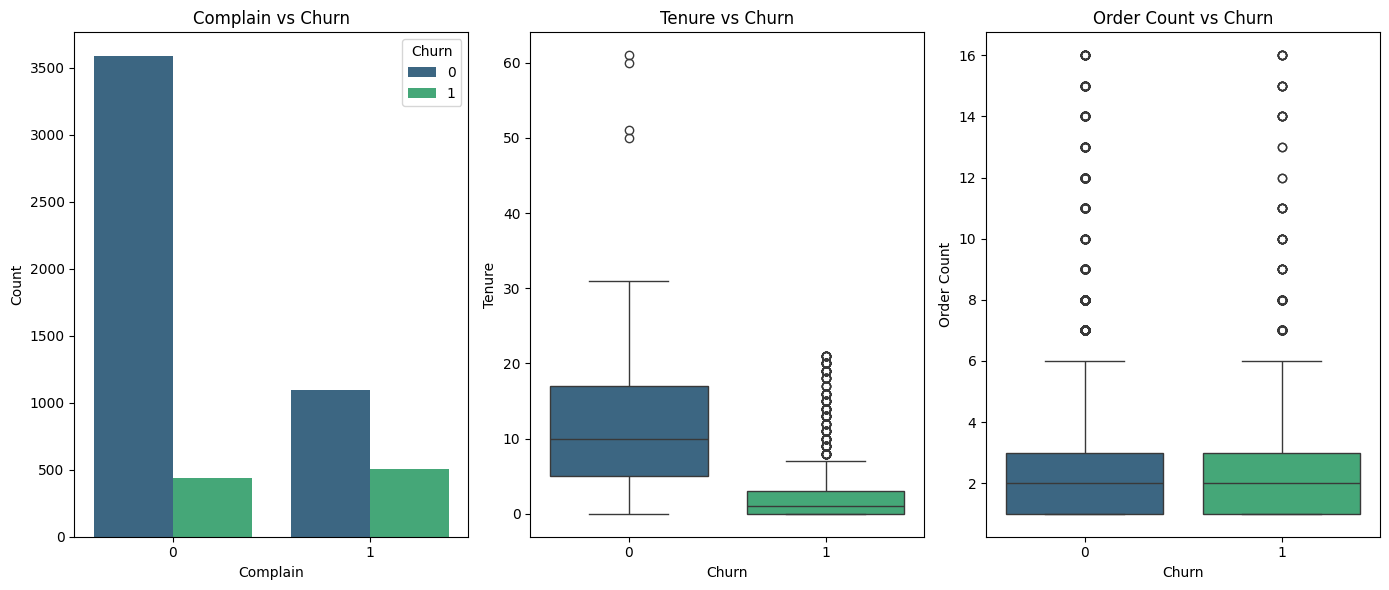

In [207]:
# Plot for Complain vs Churn
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Complain', hue='Churn', data=df, palette='viridis')
plt.title('Complain vs Churn')
plt.xlabel('Complain')
plt.ylabel('Count')

# Plot for Tenure vs Churn
plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='Tenure', data=df, palette='viridis')
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure')

# Plot for Order Count vs Churn
plt.subplot(1, 3, 3)
sns.boxplot(x='Churn', y='OrderCount', data=df, palette='viridis')
plt.title('Order Count vs Churn')
plt.xlabel('Churn')
plt.ylabel('Order Count')

plt.tight_layout()
plt.show()

In [208]:
# Separate features and target
X = df_cleaned.drop(columns=['Churn'])
y = df_cleaned['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
# Scale the features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [211]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the original number of features and the number of components after PCA
print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of components explaining 95% of the variance: {pca.n_components_}")

Original number of features: 18
Number of components explaining 95% of the variance: 15


In [212]:
# Define the logistic regression model
model = LogisticRegression(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear', 'lbfgs']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the logistic regression model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_pca, y_train)

Best parameters found by GridSearchCV:
{'C': 1, 'solver': 'liblinear'}


LogisticRegression(C=1, random_state=42, solver='liblinear')

In [213]:
# Make predictions on test set
y_test_pred = best_model.predict(X_test_pca)

# Evaluate the model on test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       301
           1       0.84      0.73      0.78       201

    accuracy                           0.84       502
   macro avg       0.84      0.82      0.83       502
weighted avg       0.84      0.84      0.84       502



In [142]:
# Define the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the random forest classifier with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_pca, y_train)

Best parameters found by GridSearchCV:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=200,
                       random_state=42)

In [143]:
# Make predictions on test set
y_test_pred = best_rf.predict(X_test_pca)

# Evaluate the model on test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       301
           1       0.93      0.85      0.89       201

    accuracy                           0.91       502
   macro avg       0.92      0.90      0.91       502
weighted avg       0.92      0.91      0.91       502



In [144]:
# Define the SVM classifier
svc = SVC(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the SVM classifier with the best parameters
best_svc = grid_search.best_estimator_
best_svc.fit(X_train_pca, y_train)

Best parameters found by GridSearchCV:
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=100, random_state=42)

In [145]:
# Make predictions on test set
y_test_pred = best_svc.predict(X_test_pca)

# Evaluate the model on test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       301
           1       0.94      0.88      0.90       201

    accuracy                           0.93       502
   macro avg       0.93      0.92      0.92       502
weighted avg       0.93      0.93      0.93       502



In [150]:
# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=pca.n_components_, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train_pca, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
51/51 [==============================] - 1s 6ms/step - loss: 0.6018 - accuracy: 0.6872 - val_loss: 0.5158 - val_accuracy: 0.7687
Epoch 2/100
51/51 [==============================] - 0s 5ms/step - loss: 0.4468 - accuracy: 0.8000 - val_loss: 0.4027 - val_accuracy: 0.8756
Epoch 3/100
51/51 [==============================] - 0s 5ms/step - loss: 0.3632 - accuracy: 0.8530 - val_loss: 0.3713 - val_accuracy: 0.8607
Epoch 4/100
51/51 [==============================] - 0s 4ms/step - loss: 0.3313 - accuracy: 0.8592 - val_loss: 0.3553 - val_accuracy: 0.8682
Epoch 5/100
51/51 [==============================] - 0s 4ms/step - loss: 0.2985 - accuracy: 0.8804 - val_loss: 0.3348 - val_accuracy: 0.8831
Epoch 6/100
51/51 [==============================] - 0s 4ms/step - loss: 0.2999 - accuracy: 0.8810 - val_loss: 0.3271 - val_accuracy: 0.8856
Epoch 7/100
51/51 [==============================] - 0s 3ms/step - loss: 0.2713 - accuracy: 0.8953 - val_loss: 0.3400 - val_accuracy: 0.8731
Epoch 8/100
5

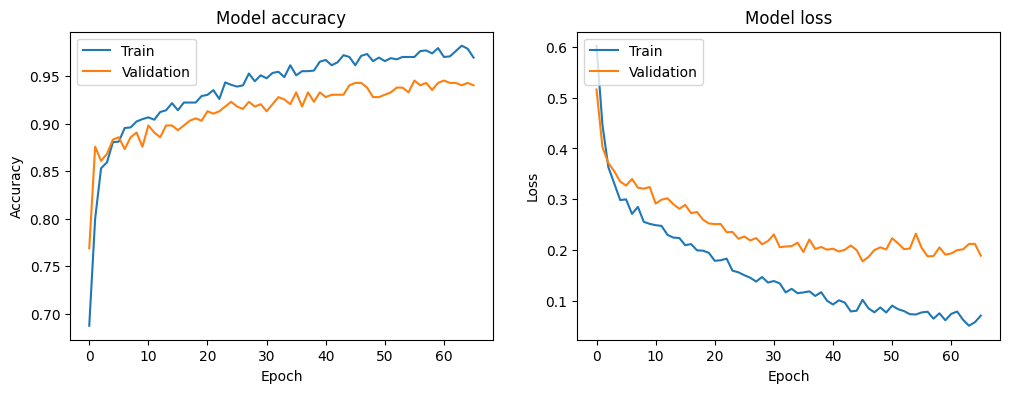

In [151]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [152]:
# Evaluate the model on the test set
y_test_pred = (model.predict(X_test_pca) > 0.5).astype("int32")

# Print classification report
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

16/16 [==============================] - 0s 1ms/step
Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       301
           1       0.93      0.85      0.89       201

    accuracy                           0.91       502
   macro avg       0.92      0.90      0.91       502
weighted avg       0.91      0.91      0.91       502



In [154]:
# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42, objective="binary:logistic", eval_metric="logloss")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the XGBoost classifier with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_pca, y_train)

Best parameters found by GridSearchCV:
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [155]:
# Make predictions on test set
y_test_pred = best_xgb.predict(X_test_pca)

# Evaluate the model on test set
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       301
           1       0.96      0.85      0.90       201

    accuracy                           0.92       502
   macro avg       0.93      0.91      0.92       502
weighted avg       0.93      0.92      0.92       502

